In [1]:
# Split the data into actual train and test on the basis of dates
# take 1 set of validation for 2 quarters
# train encode categorical features
# apply it on both the data
# smape and mape loss for lgb
# apply lgb base model and xgb base model
# application of optuna for hyper paramtuning
# ensemble of models

In [1]:
%autosave 300
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    r"/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/abi_hackathon_2k24"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/abi_hackathon_2k24


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", None)
from pandarallel import pandarallel
import re
from datetime import datetime
import gc
from sklearn.preprocessing import FunctionTransformer

# from helpers.compress import reduce_mem_usage
import pickle
import warnings

warnings.filterwarnings("ignore")

In [4]:
data_folder = "data"
macro_data_folder = "macro_data"
processed_data_folder = "processed_data_S2"
processed_macro = "macro_processed"
fe_data = "feature_engineered_data"

In [5]:
feat1_df = pd.read_pickle(os.path.join(os.getcwd(),fe_data,'sample_submission_test.pkl'))

In [6]:
feat1_df.shape,feat1_df.isnull().sum().sum()

((2214762, 48), 0)

In [7]:
feat1_df['date'] = pd.to_datetime(feat1_df[['year', 'month']].assign(day=1))
feat1_df= feat1_df.drop(['year','month','quarter'],axis=1)

In [8]:
# remove any date till end of 2019
feat1_df = feat1_df.loc[feat1_df['date']>"2019-12-31"].reset_index(drop=True)
print(feat1_df['date'].min())

2020-01-01 00:00:00


In [9]:
selected_cols = ['sales_lag_14_diff',
 'poc_ppg_id',
 'sales_roll_mean_3',
 'unique_poc_id',
 'sales_lag_13_diff',
 'quarter_cos',
 'quarter_sin',
 'windgust',
 'sales_roll_mean_6',
 'sales_ewm_alpha_09_lag_14',
 'sales_ewm_alpha_09_lag_13',
 'ppg_seasonality_index',
 'tempmax',
 'precip',
 'ppg_name',
 'humidity']+["date"]+['sales_volume_hl_agg']

feat1_df = feat1_df.loc[:,selected_cols]

In [10]:
cat_cols = feat1_df.select_dtypes(include="object").columns.tolist()
num_cols = [col for col in feat1_df.select_dtypes(include='number').columns.tolist() if col !='sales_volume_hl_agg']
print(len(cat_cols))
print(len(num_cols))

3
13


In [11]:
for cols in cat_cols:
    feat1_df[cols] = feat1_df[cols].astype("category")

In [12]:
test_cut_date = "2023-01-01"
full_train_df = feat1_df.loc[feat1_df['date']<test_cut_date].reset_index(drop=True)
test_df =  feat1_df.loc[feat1_df['date']>=test_cut_date].reset_index(drop=True)

In [13]:
full_train_df.shape,full_train_df.isnull().sum().sum()

((1347225, 18), 0)

In [14]:
test_df.shape,test_df.isnull().sum().sum()

((521820, 18), 0)

In [15]:
full_train_df.head()

,sales_lag_14_diff,poc_ppg_id,sales_roll_mean_3,unique_poc_id,sales_lag_13_diff,quarter_cos,quarter_sin,windgust,sales_roll_mean_6,sales_ewm_alpha_09_lag_14,sales_ewm_alpha_09_lag_13,ppg_seasonality_index,tempmax,precip,ppg_name,humidity,date,sales_volume_hl_agg
0,0.003751,AAAC__CJ_C_FN_M,2.661960,AAAC,-0.016176,-1.836970e-16,-1.000000e+00,43.35,2.663133,2.657029,2.657029,0.088297,18.65,0.000,CJ C FN M,68.40,2021-09-01,2.657029
1,0.006264,AAAC__CJ_C_FN_M,2.672616,AAAC,-0.018501,1.000000e+00,-2.449294e-16,44.90,2.667428,2.657029,2.657029,0.112842,22.00,0.001,CJ C FN M,68.00,2021-10-01,1.635095
2,-0.021007,AAAC__CJ_C_FN_M,2.644605,AAAC,0.005040,1.000000e+00,-2.449294e-16,46.30,2.654301,2.657029,2.657029,0.162273,22.00,0.000,CJ C FN M,65.45,2021-11-01,5.477568
3,-0.000448,AAAC__CJ_C_FN_M,2.647372,AAAC,-0.004256,1.000000e+00,-2.449294e-16,51.50,2.660954,2.657029,2.657029,0.175460,23.00,0.000,CJ C FN M,64.50,2021-12-01,4.905285
4,-0.016234,AAAC__CJ_C_FN_M,2.652205,AAAC,0.015924,6.123234e-17,1.000000e+00,41.80,2.659057,2.657029,2.657029,0.025854,27.50,0.000,CJ C FN M,64.70,2022-01-01,0.613161


In [16]:
val_date = "2022-07-01"
train_df = full_train_df.loc[full_train_df['date']<val_date].reset_index(drop=True)
val_df = full_train_df.loc[full_train_df['date']>=val_date].reset_index(drop=True)

In [17]:
train_df = train_df.drop(['date'],axis=1)
val_df = val_df.drop(['date'],axis=1)

In [18]:
train_df.shape,train_df.isnull().sum().sum()

((1090925, 17), 0)

In [19]:
val_df.shape, val_df.isnull().sum().sum()

((256300, 17), 0)

In [20]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

# Calculating SMAPE for LightGBM output:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
#     smape_val = smape(np.expm1(preds), np.expm1(labels))
    smape_val = smape(preds, labels)
    return 'SMAPE', smape_val, False

In [21]:
train_df.columns

Index(['sales_lag_14_diff', 'poc_ppg_id', 'sales_roll_mean_3', 'unique_poc_id',
       'sales_lag_13_diff', 'quarter_cos', 'quarter_sin', 'windgust',
       'sales_roll_mean_6', 'sales_ewm_alpha_09_lag_14',
       'sales_ewm_alpha_09_lag_13', 'ppg_seasonality_index', 'tempmax',
       'precip', 'ppg_name', 'humidity', 'sales_volume_hl_agg'],
      dtype='object')

In [22]:
Y_train = train_df['sales_volume_hl_agg']
X_train = train_df.drop(["sales_volume_hl_agg"],axis=1)

Y_val = val_df['sales_volume_hl_agg']
X_val = val_df.drop(["sales_volume_hl_agg"],axis=1)


In [23]:
basic_lgb_params = {'metric': {'mape'},
              'num_leaves': 15,
              'learning_rate': 0.001,
              'feature_fraction': 0.8,
              'max_depth': 10,
              'verbose': 100,
              'num_boost_round': 11000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [24]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((1090925,), (1090925, 16), (256300,), (256300, 16))

In [25]:
import lightgbm as lgb

In [26]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cat_cols+num_cols,categorical_feature=cat_cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cat_cols+num_cols,categorical_feature=cat_cols)

In [27]:
model = lgb.train(basic_lgb_params, 
                  lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=basic_lgb_params['num_boost_round'],
                  feval=lgbm_smape,
                 valid_names=['train', 'valid'])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.101759
[LightGBM] [Debug] init for col-wise cost 0.000013 seconds, init for row-wise cost 0.012560 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 36115
[LightGBM] [Info] Number of data points in the train set: 1090925, number of used features: 16
[LightGBM] [Info] Start training from score 11.368880
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
Training until validation scores don't improve for 200 rounds
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Train

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Traine

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trai

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trai

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Train

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Train

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Train

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Tra

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Tr

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug]

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [D

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug]

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [De

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug]

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug]

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Tra

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [D

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [D

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug]

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 4
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Deb

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 5
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] 

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debu

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [D

[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 15 and depth = 10
[LightGBM] [Debu

In [28]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [28]:
# smape(np.expm1(y_pred_val), np.expm1(Y_val))

In [29]:
smape(y_pred_val, Y_val)

88.33631593008899

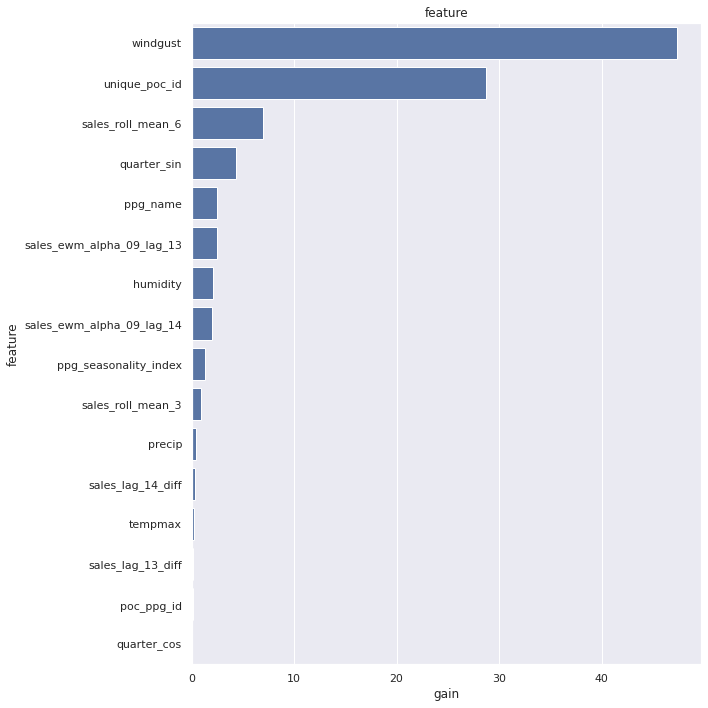

In [30]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False).reset_index(drop=True)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
        
    return(feat_imp)



feat_imp = plot_lgb_importances(model, num=30, plot=True)

In [39]:
n_feats = feat_imp.loc[:15,'feature'].unique().tolist()

In [40]:
n_feats

['sales_lag_14_diff',
 'poc_ppg_id',
 'sales_roll_mean_3',
 'unique_poc_id',
 'sales_lag_13_diff',
 'quarter_cos',
 'quarter_sin',
 'windgust',
 'sales_roll_mean_6',
 'sales_ewm_alpha_09_lag_14',
 'sales_ewm_alpha_09_lag_13',
 'ppg_seasonality_index',
 'tempmax',
 'precip',
 'ppg_name',
 'humidity']